## Task 1

С точки зрения NLP, дана задача NER(Named Entity Recognition). В данной задаче требуется выделить в тексте определенные сущности. Выделяемым обектом для конкретной сущности является последовательность слов, в которую обычно входит от 1 до n слов, где n является натуральным числом, зачастую не слишком большого размера, но в некоторых случаях может достигать нескольких сотен слов. Примеры сущностей уже даны в текущем тестовом задании.
Решением данной задачи является создание эмбеддингов текста и обучение классификатора, который для текстового представления каждого токена выдает предсказание в виде например вероятности того, что данный токен является заданной сущностью. Также обычно создается BIO разметка, которая созадёт границы сущности в текстовом представлении. B - соответствует первому токену сущности, O --- любому токену, который не является сущностью, а I --- токенам, котрые являются сущностью, но не являются началом. У каждой сущности BIO выглядит по-своему, например для имени она будет выглядеть так: B-PER, I-PER, O --- выглядит всегда одинаковый.  
Имеется два способа для решения данного вида задач при помощи LLM:
1) Используя encoder модели, зачастую используются BERT-like модели. Данный метод до сих пор является одним из лучших для решения таких задач(по моему скромному мнению он --- лучший).  
В кратце о том как оно работает:
  - Текст токинезируется
  - Создается BIO разметка
  - модель создаёт эмбединг
  - затем они проходят через Token Classification Head \
В качестве лосса обычно тут испольуется Cross-Entropy
2) При помощи decoder моделей.
Данный метод стал набирать свою популярность с активным повышением качества генерируемого текста моделями. Работает он на основе подачи запросов в LLM, в которых содержится условие задачи без конкретного предложения, зачастую это в систем промпте, а в основной части уже конкретный кейс(если модель придумывает что-то новое, можно вежливо попросить её не галлюцинировать. спойлер: обычно это не помогает).
Для оценки качества обычно используются Precision, Recall, F1 мера и accuracy.
Обычно в TP входят случаи, в которых для конкретной сущности BIO, включая начальный и конечный индекс, совпало с предсказанием.



## Task 2

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import unittest

from collections import defaultdict
from typing import List

In [ ]:
directory_text_path = 'sample_data/brexit_text'
directory_annotated_path = 'sample_data/brexit_annotated'

Для начала я сохраню тексты и соответствующие им сущности в массивы.

In [ ]:
def read_dir(dir_path):
  res = []
  for filename in sorted(os.listdir(dir_path)):
    file_path = os.path.join(dir_path, filename)
    with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                res.append(content)

  return res

directory_text_path = 'sample_data/brexit_text'
directory_annotated_path = 'sample_data/brexit_annotated'

document_text = read_dir(directory_text_path)
annotated = read_dir(directory_annotated_path)

Далее я выделю сущности и соответствующие им последовательности слов.

In [ ]:
entity = [[] for _ in range(len(annotated))]
gold_answer = [[] for _ in range(len(annotated))]
for i in range(len(annotated)):
  #в конце аннотации присутствует пустая строка поэтому [:-1]
  rows = annotated[i].split('\n')[1:-1]
  for row in rows:
    entity[i].append(row.split('\t')[2])
    gold_answer[i].append(row.split('\t')[0])

print(gold_answer[0])

['Brexit', 'Альбиона', 'Альбионе', 'Борис Джонсон', 'Британии', 'Британия', 'Брюсселе', 'Брюсселем', 'Брюссель', 'Брюсселю', 'Брюсселя', 'Джонсон', 'Джонсона', 'ЕС', 'Еврокомиссия', 'Европа', 'Европе', 'Европейскому', 'Европой', 'Европы', 'Евросоюза', 'Евросоюзом', 'Консервативной партии', 'Ла-Манша', 'Лондон', 'Лондона', 'Лондоне', 'Лондону', 'Международного валютного фонда', 'Мишелю Барнье', 'Мэй', 'Себастьян Курц', 'Северную Ирландию', 'Соединенного Королевства', 'Тереза Мэй', 'Терезу', 'брекзит', 'брекзита', 'брекзиту', 'брексит', 'британском парламенте', 'британскому парламентам', 'лейбористы', 'тори']


В следующей ячейке я выделю номера текстов из названий их файлов

In [ ]:
document_ids = []

for filename in sorted(os.listdir(directory_text_path)):
  cropped_prefix = filename.removeprefix('brexit_ru.txt_file_')
  document_ids.append(int(cropped_prefix.removesuffix('.txt')))

print(document_ids)

[10, 1000, 1001, 1002, 1003, 1004, 1006, 1011, 1017]


Далее я создаю DataFrame и в клонке document_text удаляю первые 4 строки, которые не являются содержимым самого текста.

In [ ]:
df = pd.DataFrame({'document_ids': document_ids,
                   'document_text': document_text,
                   'entity': entity,
                   'gold_answer': gold_answer})

df.document_text = df.document_text.apply(lambda x: '\n'.join(x.split('\n')[4:]))
df.head()

,document_ids,document_text,entity,gold_answer
0,10,Тереза Мэй рассчитывает усидеть в седле до зав...,"[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр..."
1,1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Brexit, The Guardian, Борис Джонсон, Бориса Д..."
2,1001,Глава МИД Британии Борис Джонсон подал в отста...,"[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Associated Press, Brexit, Борис Джонсон, Бори..."
3,1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"[PER, EVT, LOC, PER, ORG, ORG, PER]","[Бориса Джонсона, Брекзит, Великобритании, Дэв..."
4,1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[Борис Джонсон, Великобритании, Даунинг-Стрит,..."


## Task 3

  prompt = f'Привет. Ты высококвалифицированный специалист в области извлечения именованных сущностей. Извлеки именованные сущности из следующего текста. Из текста ты должен извлечь следующие сущности: \n 1)PER --- Эта категория охватывает поименованные ссылки на отдельных людей или семьи, а также некоторые поименованные ссылки на группы людей. Имена людей не должны включать в себя титулы, обращения и должности.Поименованные упоминания других групп людей, которые имеют формальный статус организация, объединяющая их, должна быть помечена как PER/. Не следует извлекать объединяющие их фразы, например, «мусульмане». \n 2) ORG --- Эта категория охватывает все виды организаций, такие как: политические партии, общественные организации учреждения и другие. \n 3) LOC --- в эту категорию входят все топонимы (например, города, округа, провинции, регионы, водоемы, геологические образования и т.д.) и поименованные упоминания объекты, т. е. функциональные и в первую очередь искусственные сооружения, такие как: стадионы, парки, музеи, театры и т.д. \n 4) EVT --- та категория охватывает поименованные упоминания событий, включая: (а) случаи например, конференции, например «24. Конференция Жаровного Зинковани», концерты, Festivales, праздники, например, «Święta Bożego Narodzenia» (англ. Christmas), (б) инциденты, такие как войны, сражения и техногенные катастрофы, например, «Катастрофа Чернобыльская» - Чернобыльская катастрофа и (в) стихийные бедствия и явления.\n 5) PRO --- в эту категорию входят названия продуктов, в том числе: электроника (например, «Motorola Moto Z Play»O, автомобили (например, «Subaru Forester XT»), транспортные средства (например, «Fiat «Панда»), оружие (например, «Калашников АК-47»), веб-сервисы (например, «Твиттер»), книги (например, «Гарри Поттер и философский камень»), программное обеспечение (например, «MS Office»), газеты (например, «The New York Times») и другие произведения искусства и т. д. б. Названия юридических документов (например, «dyrektywy 2001/14/we Parlamentu Европейского и Рады»), договоры, например, «Трактат Лижбонский» (англ. Лиссабон), инициативы/программы (например,«Горизонт 2020») также рассматриваются названия продуктов. \n Выведи все именованные сущности в тексте в формате JSON. Используй следующую структуру: список словарей, с ключами entity (тип сущности, работай только с теми сущностями, про которые я написал тебе) и name(текст сущности) \nНомер документа: {row.document_ids} \n Текст:\n {row.document_text}'


In [ ]:
def buid_prompt(row: pd.Series) -> str:
  prompt = f'Привет. Ты высококвалифицированный специалист в области извлечения именованных сущностей. Извлеки именованные сущности из следующего текста. Из текста ты должен извлечь следующие сущности: \n 1)PER --- Эта категория охватывает поименованные ссылки на отдельных людей или семьи, а также некоторые поименованные ссылки на группы людей. Имена людей не должны включать в себя титулы, обращения и должности.Поименованные упоминания других групп людей, которые имеют формальный статус организация, объединяющая их, должна быть помечена как PER/. Не следует извлекать объединяющие их фразы, например, «мусульмане». \n 2) ORG --- Эта категория охватывает все виды организаций, такие как: политические партии, общественные организации учреждения и другие. \n 3) LOC --- в эту категорию входят все топонимы (например, города, округа, провинции, регионы, водоемы, геологические образования и т.д.) и поименованные упоминания объекты, т. е. функциональные и в первую очередь искусственные сооружения, такие как: стадионы, парки, музеи, театры и т.д. \n 4) EVT --- та категория охватывает поименованные упоминания событий, включая: (а) случаи например, конференции, например «24. Конференция Жаровного Зинковани», концерты, Festivales, праздники, например, «Święta Bożego Narodzenia» (англ. Christmas), (б) инциденты, такие как войны, сражения и техногенные катастрофы, например, «Катастрофа Чернобыльская» - Чернобыльская катастрофа и (в) стихийные бедствия и явления.\n 5) PRO --- в эту категорию входят названия продуктов, в том числе: электроника (например, «Motorola Moto Z Play»O, автомобили (например, «Subaru Forester XT»), транспортные средства (например, «Fiat «Панда»), оружие (например, «Калашников АК-47»), веб-сервисы (например, «Твиттер»), книги (например, «Гарри Поттер и философский камень»), программное обеспечение (например, «MS Office»), газеты (например, «The New York Times») и другие произведения искусства и т. д. б. Названия юридических документов (например, «dyrektywy 2001/14/we Parlamentu Европейского и Рады»), договоры, например, «Трактат Лижбонский» (англ. Лиссабон), инициативы/программы (например,«Горизонт 2020») также рассматриваются названия продуктов. \n Выведи все именованные сущности в тексте в формате JSON. Используй следующую структуру: список словарей, с ключами entity (тип сущности, работай только с теми сущностями, про которые я написал тебе) и name(текст сущности) \nНомер документа: {row.document_ids} \n Текст:\n {row.document_text} \n\n'
  return prompt


In [ ]:
with open("prompts.txt", 'w', encoding='utf-8') as f:
  for i in range(df.shape[0]):
    f.write(buid_prompt(df.loc[i]))

## Task 4

In [ ]:
responses = []
responses_dir = 'responses'

for filename in sorted(os.listdir(responses_dir)):
  file_path = os.path.join(responses_dir, filename)
  try:
    with open(file_path, 'r') as f:
      response = json.load(f)
      responses.append(response)
  except:
    continue

df['responses'] = responses
df.head()

,document_ids,document_text,entity,gold_answer,responses
0,10,Тереза Мэй рассчитывает усидеть в седле до зав...,"[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[{'entity': 'PER', 'name': 'Тереза Мэй'}, {'en..."
1,1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[{'entity': 'ORG', 'name': 'Подробности.ua'}, ..."
2,1001,Глава МИД Британии Борис Джонсон подал в отста...,"[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Associated Press, Brexit, Борис Джонсон, Бори...","[{'entity': 'ORG', 'name': 'МИД Британии'}, {'..."
3,1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"[PER, EVT, LOC, PER, ORG, ORG, PER]","[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[{'entity': 'PER', 'name': 'Тереза Мей'}, {'en..."
4,1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[{'entity': 'ORG', 'name': 'Министерство иност..."


## Task 5

In [ ]:
def score_fn(gold: list, pred: list):
    results = []
    for i in range(len(gold)):
        tp = 0
        for gold_entity in gold[i]:
          if gold_entity in pred[i]:
            tp += 1

        fn = len(gold[i]) - tp
        fp = len(pred[i]) - tp
        results.append({'tp': tp, 'fp': fp, 'fn': fn})

    total_tp = sum(r['tp'] for r in results)
    total_fp = sum(r['fp'] for r in results)
    total_fn = sum(r['fn'] for r in results)

    if total_tp == 0:
      return 0, 0, 0

    micro_precision = total_tp / (total_tp + total_fp)
    micro_recall = total_tp / (total_tp + total_fn)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    return micro_precision, micro_recall,  micro_f1


Юнит-тесты

In [ ]:
import unittest

class TestScoreFn(unittest.TestCase):

    def test_perfect_match(self):
        """Тест на идеальное совпадение"""
        gold = [[{"entity": "PER", "name": "Иван Иванов"}, {"entity": "LOC", "name": "Москва"}]]
        pred = [[{"entity": "PER", "name": "Иван Иванов"}, {"entity": "LOC", "name": "Москва"}]]
        precision, recall, f1 = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 1.0)
        self.assertEqual(f1, 1.0)

    def test_partial_match_missing_entity(self):
        """Тест на частичное совпадение (пропущена сущность)"""
        gold = [[{"entity": "PER", "name": "Иван Иванов"}, {"entity": "LOC", "name": "Москва"}]]
        pred = [[{"entity": "PER", "name": "Иван Иванов"}]]
        precision, recall, f1 = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 0.5)
        self.assertAlmostEqual(f1, 2/3, places=5)

    def test_wrong_entity_type(self):
        """Тест на неправильный тип сущности"""
        gold = [[{"entity": "PER", "name": "Иван Иванов"}]]
        pred = [[{"entity": "ORG", "name": "Иван Иванов"}]]
        precision, recall, f1 = score_fn(gold, pred)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)
        self.assertEqual(f1, 0.0)

    def test_wrong_entity_name(self):
        """Тест на неправильное имя сущности"""
        gold = [[{"entity": "PER", "name": "Иван Иванов"}]]
        pred = [[{"entity": "PER", "name": "Иван Петров"}]]
        precision, recall, f1 = score_fn(gold, pred)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)
        self.assertEqual(f1, 0.0)

    def test_multiple_examples(self):
        """Тест на нескольких примерах"""
        gold = [
            [{"entity": "PER", "name": "Иван Иванов"}, {"entity": "LOC", "name": "Москва"}],
            [{"entity": "ORG", "name": "Яндекс"}],
            [{"entity": "PER", "name": "Мария"}, {"entity": "LOC", "name": "Санкт-Петербург"}]
        ]
        pred = [
            [{"entity": "PER", "name": "Иван Иванов"}],
            [{"entity": "ORG", "name": "Яндекс"}],
            []
        ]
        precision, recall, f1 = score_fn(gold, pred)
        self.assertEqual(precision, 1.0)
        self.assertEqual(recall, 0.4)
        self.assertAlmostEqual(f1, 0.5714, places=4)

if __name__ == '__main__':
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(TestScoreFn)
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)

    print(f"\nСтатистика тестов:")
    print(f"Пройдено: {result.testsRun - len(result.failures) - len(result.errors)}")
    print(f"Провалено: {len(result.failures)}")
    print(f"Ошибок: {len(result.errors)}")

test_multiple_examples (__main__.TestScoreFn.test_multiple_examples)
Тест на нескольких примерах ... ok
test_partial_match_missing_entity (__main__.TestScoreFn.test_partial_match_missing_entity)
Тест на частичное совпадение (пропущена сущность) ... ok
test_perfect_match (__main__.TestScoreFn.test_perfect_match)
Тест на идеальное совпадение ... ok
test_wrong_entity_name (__main__.TestScoreFn.test_wrong_entity_name)
Тест на неправильное имя сущности ... ok
test_wrong_entity_type (__main__.TestScoreFn.test_wrong_entity_type)
Тест на неправильный тип сущности ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK



Статистика тестов:
Пройдено: 5
Провалено: 0
Ошибок: 0


Micro Precision: 0.5955
Micro Recall: 0.3464
Micro F1: 0.4380

Возможно ли ускорить вычисление функции через векторную реализацию?

Да, ускорить вычисление функции можно при помощи библиотеки numpy, благодаря оптимизированным операциям, которые принадлежат данной библиотеке.

Для оценки качества были выбраны метрики: precision, recall и f1-score в разновидности micro. Обычно при расчёте данных метрик, количство предиктов равно количеству истинных значений таргетов, но в данном случае модель может найти лишние сущности или наоборот упустить какие-то, чтобы учитывать данный момент, в рассчёты FP были включены лишние, найденные моделью сущностью, а в FN недостающие.
В подобных задачах f1 является наилучшей метрикой, т.к является средним гармоническим от precision и recall, а это значит, что достаточно учитывает данные метрики. Precison является показателем того, насколько часто модель находит лишние сущности, а recall, того, насколько часто не находит нужные(очень грубо говоря).   

## Task 6

В данной ячейке данные подгатавливаются для подсчёта метрик

In [ ]:
by_text_gold = []
by_entity_gold = defaultdict(list)
by_entity_responses = defaultdict(list)
for i in range(df.shape[0]):
    sub_gold = []
    for entity_type, entity_name in zip(df.entity.loc[i], df.gold_answer.loc[i]):
      sub_gold.append({"entity": entity_type, 'name': entity_name})
      by_entity_gold[entity_type].append({"entity": entity_type, 'name': entity_name})
    by_text_gold.append(sub_gold)

    for d in df.responses.loc[i]:
          by_entity_responses[d["entity"]].append(d)

### A) Расчёт метрик по каждой сущности

In [ ]:
scored_by_entity = defaultdict(list)
for k in by_entity_gold:
    score = score_fn([by_entity_gold[k]], [by_entity_responses[k]])
    scored_by_entity[k] = (score)
    print(f'entity: {k}, precision: {score[0]:.3f}, recall: {score[1]:.3f}, f1-score: {score[2]:.3f}')

entity: EVT, precision: 1.000, recall: 0.615, f1-score: 0.762
entity: LOC, precision: 0.444, recall: 0.111, f1-score: 0.178
entity: PER, precision: 0.897, recall: 0.413, f1-score: 0.565
entity: ORG, precision: 0.419, recall: 0.500, f1-score: 0.456
entity: PRO, precision: 0.000, recall: 0.000, f1-score: 0.000


### Б)Расчёт метрик по каждому документу

In [ ]:
scored_by_text = defaultdict(list)
sorted_by_length = {}
for i in range(len(by_text_gold)):
    score = score_fn([by_text_gold[i]], [df.responses[i]])
    scored_by_text[df.document_ids[i]] = (score)
    sorted_by_length[len(df.document_text[i])] = score
    print(f'doc_id: {df.document_ids[i]}, precision: {score[0]:.3f}, recall: {score[1]:.3f}, f1-score: {score[2]:.3f}')

doc_id: 10, precision: 0.533, recall: 0.182, f1-score: 0.271
doc_id: 1000, precision: 0.636, recall: 0.500, f1-score: 0.560
doc_id: 1001, precision: 0.857, recall: 0.429, f1-score: 0.571
doc_id: 1002, precision: 0.667, recall: 0.571, f1-score: 0.615
doc_id: 1003, precision: 0.444, recall: 0.400, f1-score: 0.421
doc_id: 1004, precision: 0.462, recall: 0.333, f1-score: 0.387
doc_id: 1006, precision: 0.667, recall: 0.462, f1-score: 0.545
doc_id: 1011, precision: 0.556, recall: 0.278, f1-score: 0.370
doc_id: 1017, precision: 0.700, recall: 0.467, f1-score: 0.560


In [ ]:
def build_histogram(data, title):
    entities = []
    precisions = []
    recalls = []
    f1_scores = []

    for entity, metrics_list in data.items():
        entities.append(entity)
        precisions.append(metrics_list[0])
        recalls.append(metrics_list[1])
        f1_scores.append(metrics_list[2])

    x = np.arange(len(entities))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, precisions, width, label='Precision', color='royalblue')
    rects2 = ax.bar(x, recalls, width, label='Recall', color='orange')
    rects3 = ax.bar(x + width, f1_scores, width, label='F1-score', color='green')

    ax.set_xlabel('Сущности', fontsize=12)
    ax.set_ylabel('Значения метрик', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(entities, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

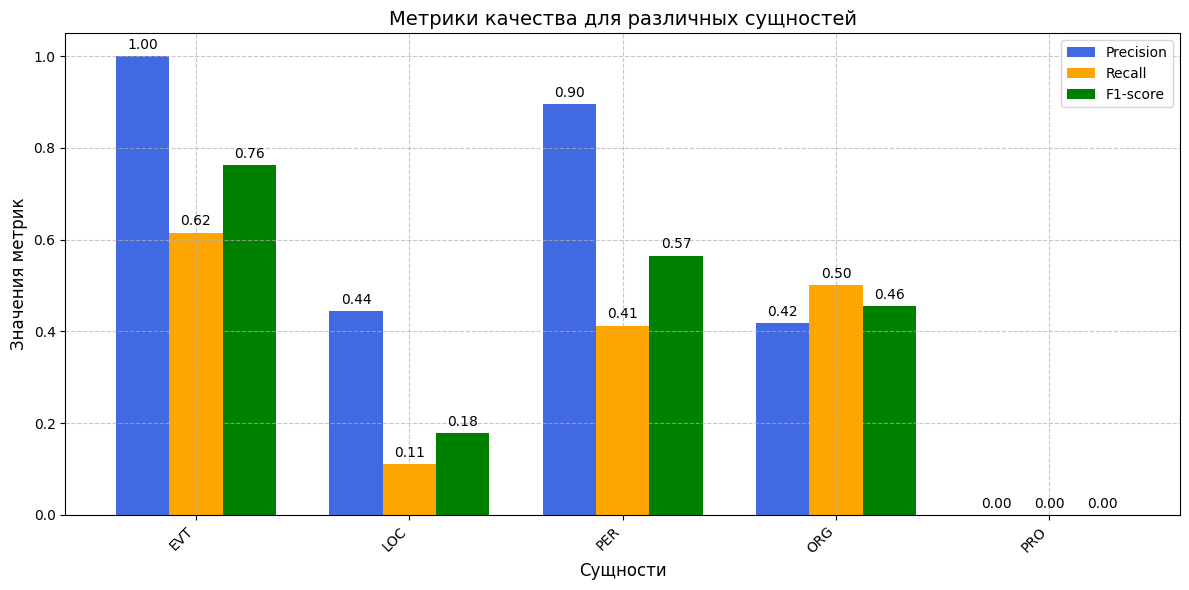

In [ ]:
build_histogram(scored_by_entity, title='Метрики качества для различных сущностей')

По данной гистограмме можно сказать, что результат имеет неплохую точность, но зачастую модель плохо находит нужные сущности. Самой проблемной является сущность LOC, возможно стоит обратить внимание на локации, которые имеются в тексте и уточнить в промпте их особенности. Исходя из разметки к сущности PRO относится всего один сэмпл и если модель его не нашла, то любая из метрик будет равна 0, что и произошло в данной ситуации. В общем, можно сказать, что решение не очень хорошо справляется со своей задачей, так как на всех сущностях значение метрик достаточно низкое, для сущностей с низкими показателями стоит изучить примеры более деталльно и внести изменения в промпт.

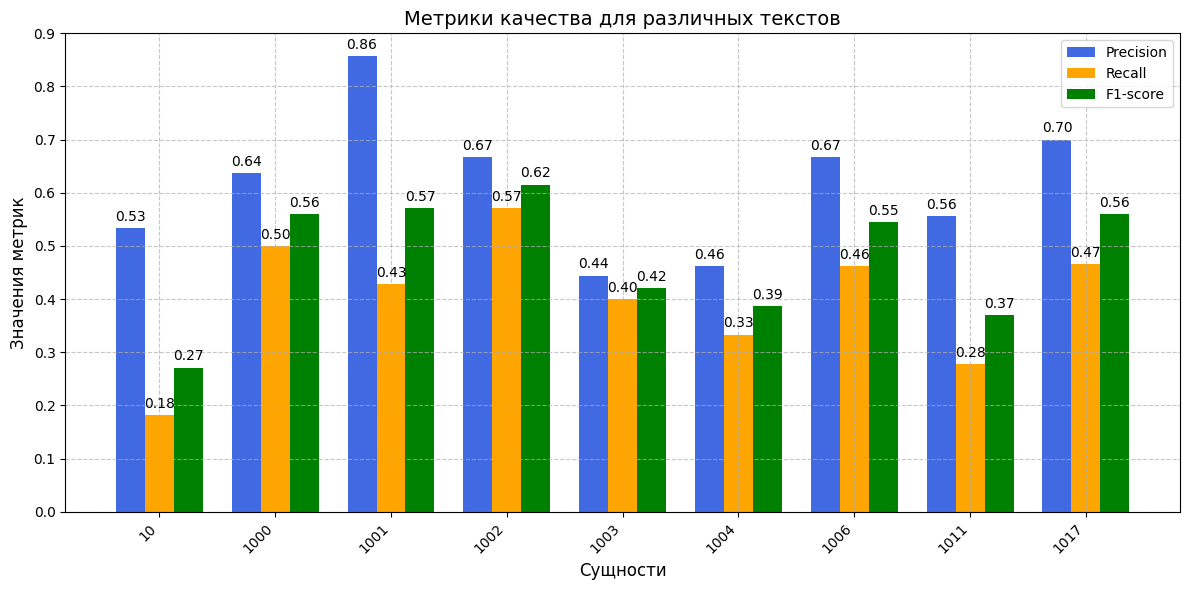

In [ ]:
build_histogram(scored_by_text, title='Метрики качества для различных текстов')

Смотря на гистограмму для текстов, можно сказать, что в среднем качество чуть хуже срднего. Во всех текстах precision превышает recall, что говорит о том, что модель не находит достаточно большое количество сущностей. В тексте 10 низкое значение метрики precision, возможно в данном тексте количество сущностей больше чем в других(возможно просто текст самый большой из представленных) или сущности достаточно своеобразные.

## Task 7

{437: (0.6666666666666666, 0.5714285714285714, 0.6153846153846153), 492: (0.4444444444444444, 0.4, 0.4210526315789474), 691: (0.8571428571428571, 0.42857142857142855, 0.5714285714285714), 840: (0.6666666666666666, 0.46153846153846156, 0.5454545454545455), 880: (0.6363636363636364, 0.5, 0.56), 956: (0.7, 0.4666666666666667, 0.56), 1093: (0.46153846153846156, 0.3333333333333333, 0.3870967741935484), 1642: (0.5555555555555556, 0.2777777777777778, 0.3703703703703704), 5161: (0.5333333333333333, 0.18181818181818182, 0.2711864406779661)}


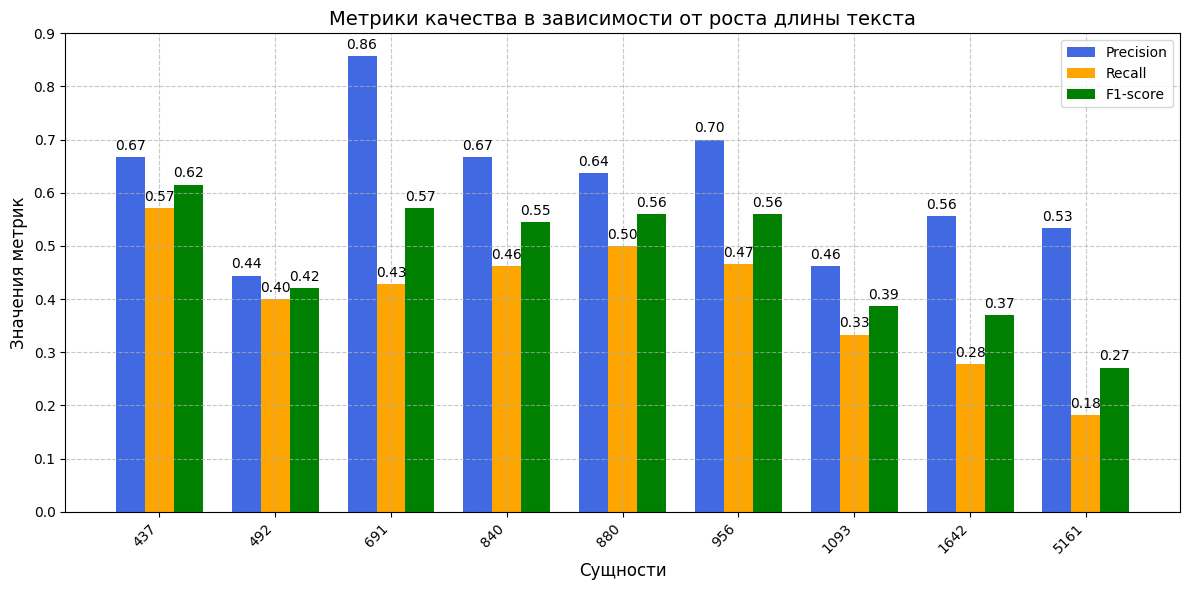

In [ ]:
sorted_by_length = dict(sorted(sorted_by_length.items()))
print(sorted_by_length)
build_histogram(sorted_by_length, title="Метрики качества в зависимости от роста длины текста")

В данном случае зависимость митик от длины текста имеется.

## Task 8

Модель как уже было понятно из предыдущего задания, ошибается в более длинных текстах. Чтобы решить данную проблему, я бы делил тексты на подтексты примерно одинаковой длины, найдя заранее достаточно оптимальное значение длины текста.

Также модель очень плохо справилась с сущностью LOC, она не добавляла Британию и Альбиону. Тут проблема скорее всего в том, что Британия это скоращение от Великобритания, а модель слишком формально решила выделять данный тип сущностей. Чтобы решить это, в промпте стоит добавить уточнение по поводу видоизмененных названий стран или как-то других локаций. Альбион же является устаревшим названием возможно модель не знает этого названия, но я уверен, что она должна это знать. Чтобы решить эту проблему вместе с прошлой, стоит кардинально изменить часть про LOC в промпте.      

Также стоит изменить часть промта, которая связана с PER, добавив в промпте некое расширение круга возможных вариантов для данной сущности.


In [ ]:
for k in by_entity_responses:
  print(f'entity: {k}, difference: {abs(len(by_entity_gold[k]) - len(by_entity_responses[k]))}')

entity: PER, difference: 34
entity: ORG, difference: 7
entity: LOC, difference: 27
entity: EVT, difference: 5
entity: PRO, difference: 5


## Task 9

Исследование показало, что у генеративных моделей есть будущее в решение задач NER. Возможно подобное расширит функционал **агентов** через некоторое время, хотя как мне кажется, энкодер модель пока что решает данную задачу лучше.

Первый раз в жизни я решал ниры при помощи генреративной модели. Также было интересно подумать над метрикой, были и идеи получше, но честно говоря не было уверенности в их реализации.